# 1. Install Dependencies and Setup

In [ ]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [1]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      1.4.0
ALTER-NLU                    1.0.0
anyio                        3.6.2
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        22.2.0
audioread                    3.0.0
autopep8                     2.0.1
backcall                     0.2.0
beautifulsoup4               4.11.1
bleach                       6.0.0
blis                         0.7.9
cachetools                   5.3.0
catalogue                    2.0.8
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.2
confection                   0.0.4
contourpy                    1.0.7
cy

In [2]:
import tensorflow as tf
import os

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data', batch_size=32, image_size=(480, 360))

Found 305 files belonging to 2 classes.


In [4]:
data_iterator = data.as_numpy_iterator()

In [8]:
batch = data_iterator.next()

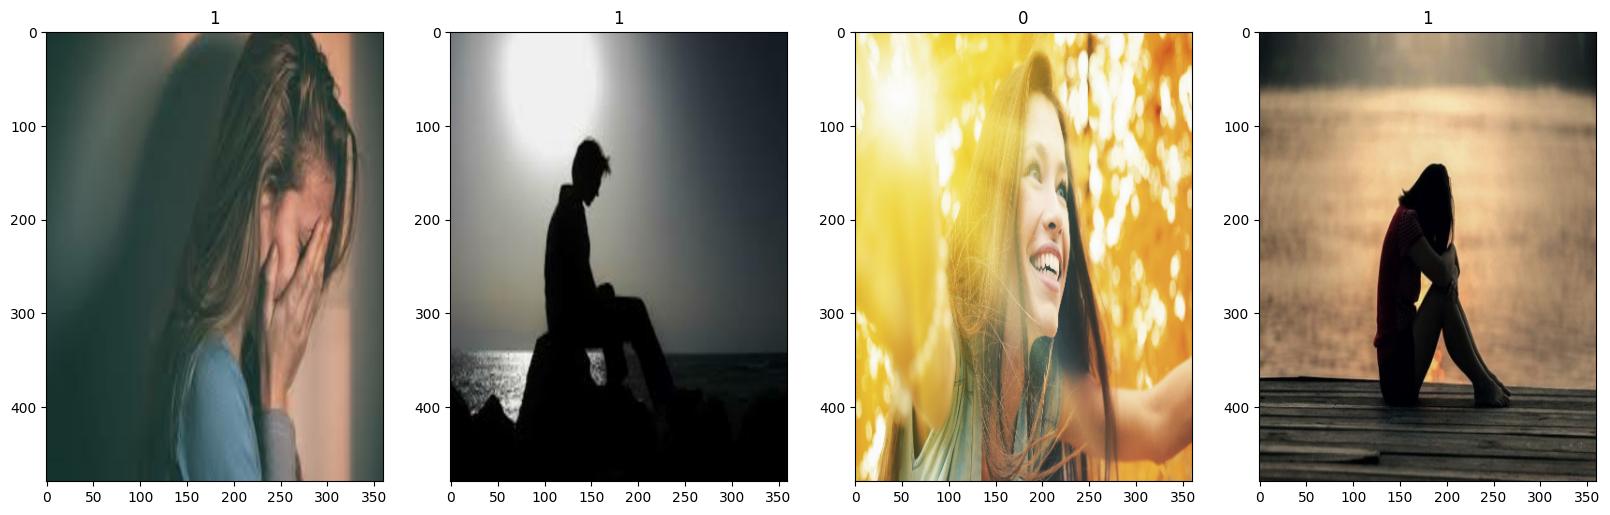

In [9]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

# 5. Split Data

In [14]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

7

In [15]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [16]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

# 8. Plot Performance

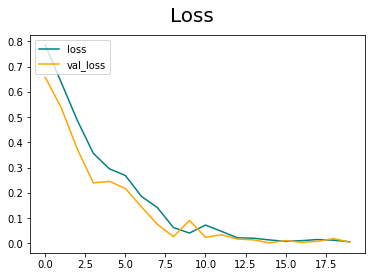

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

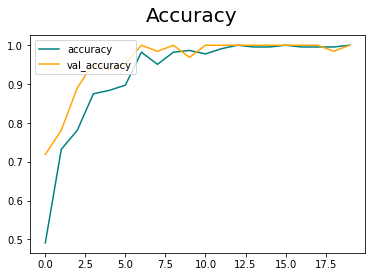

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

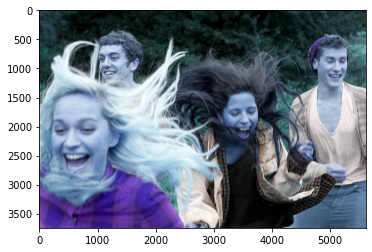

In [39]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

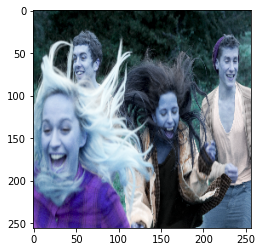

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [42]:
yhat

array([[0.01972741]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)